<a href="https://colab.research.google.com/github/etoro2306/capstone_project/blob/dev/FINAL_VERSION_SIDES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  shutil.rmtree("/content/capstone_project")
except: pass

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn
import os
import cv2
from google.colab.patches import cv2_imshow
import shutil
from PIL import Image, ImageDraw, ImageFont
from PIL.ImageFont import truetype
from natsort import natsorted

In [3]:
repository_name = "capstone_project"

In [4]:
!git clone https://github.com/etoro2306/{repository_name}
%cd {repository_name}

Cloning into 'capstone_project'...
remote: Enumerating objects: 542, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 542 (delta 69), reused 66 (delta 66), pack-reused 467
Receiving objects: 100% (542/542), 74.03 MiB | 14.00 MiB/s, done.
Resolving deltas: 100% (147/147), done.
/content/capstone_project


In [5]:
!ls

arial.ttf  capstone_project_notebook.ipynb  data  README.md


In [6]:
os.chdir('/content/capstone_project/data/')

## Uploading and uniforming the data

**1st. Read the images that are inside the `data` folder and store them on a variable called `images`.** 

In [7]:
images = []
image_files = natsorted(os.listdir())
for image_file in image_files:
    image = cv2.imread(image_file)
    images.append(image)

**2nd. Checking the shape of the images (first 5 images as sample).** 

In [8]:
for i in range(7):
  print(images[i].shape)


(475, 1578, 3)
(475, 1578, 3)
(475, 1578, 3)
(475, 1578, 3)
(475, 1578, 3)
(475, 1578, 3)
(475, 1578, 3)


The images have different shape, so we will standardize all the images in order to have the same shape

In [9]:
for i, im in enumerate(images):
    # Convert the image to a PIL image object
    im = Image.fromarray(im)

    # Resize the image
    im_resized = im.resize((1578, 475))

    # Convert the resized image back to a NumPy array
    images[i] = np.array(im_resized)

Recheck the images shape (first 5 images again).

In [10]:
for i in range(5):
  print(images[i].shape)

(475, 1578, 3)
(475, 1578, 3)
(475, 1578, 3)
(475, 1578, 3)
(475, 1578, 3)


**3rd. Display some images to check that they have benn uploaded correctly.** 

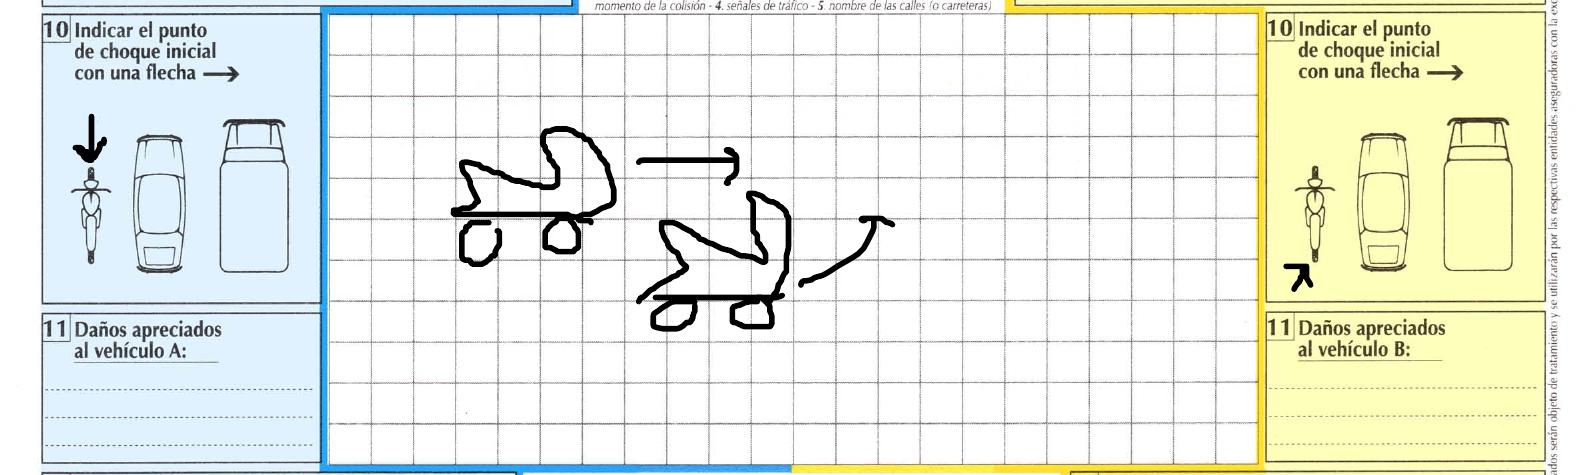

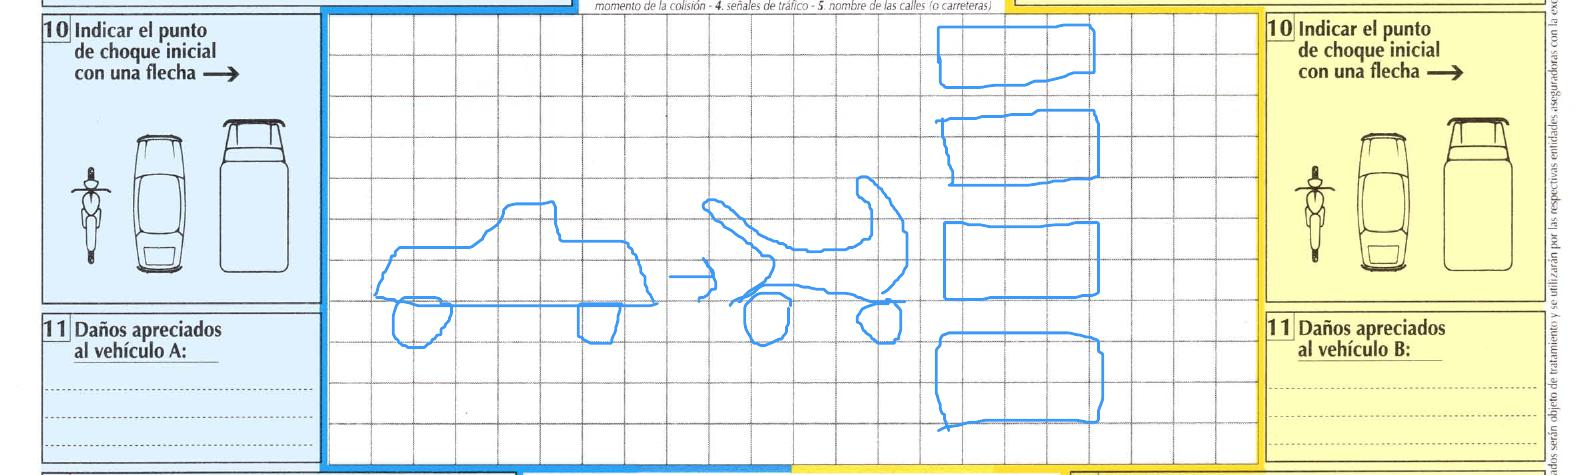

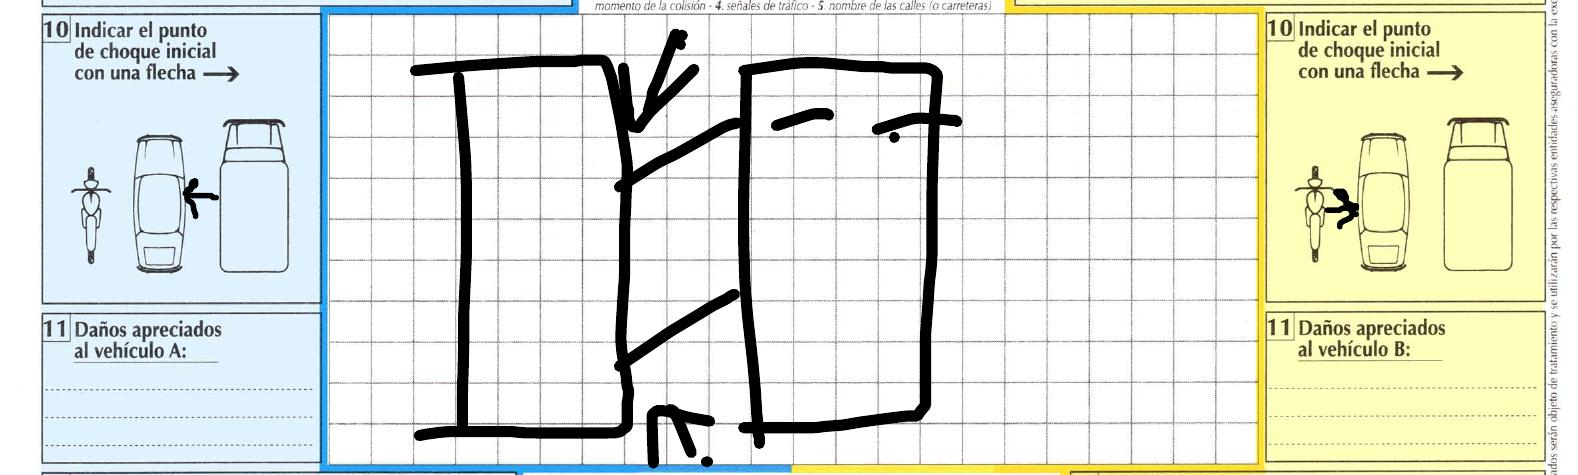

In [50]:
cv2_imshow(images[44])
cv2_imshow(images[32])
cv2_imshow(images[45])

## Detection of type of vehicles (A and B)

**1st. Crop the images to keep only the parts needed**

In [12]:
left_cropped_images = []
for image in images:
    height, width = image.shape[:2]
    cropped_image = image[:, 40:320]
    mask = (cropped_image[:,:,0] > 220) & (cropped_image[:,:,2] < 110)
    cropped_image[mask] = [0, 0, 0]
    mask = (cropped_image[:,:,2] > 220) & (cropped_image[:,:,0] < 130)
    cropped_image[mask] = [0, 0, 0]
    left_cropped_images.append(cropped_image)

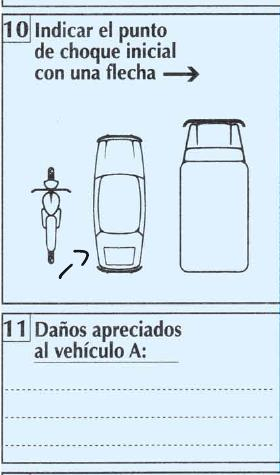

In [53]:
cv2_imshow(left_cropped_images[71])

**2nd. Do the thresholding process to keep the extra lines drawn on the images.**

In [14]:
# Set the threshold value
threshold_value = 30

# Create an empty list to store the thresholded images
th_left_cropped_images = []

# Loop through the images in left_cropped_images
for image in left_cropped_images:
  # Convert the image to grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
  # Apply global thresholding
  _, threshold = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)
  
  # Add the thresholded image to the list
  th_left_cropped_images.append(threshold)


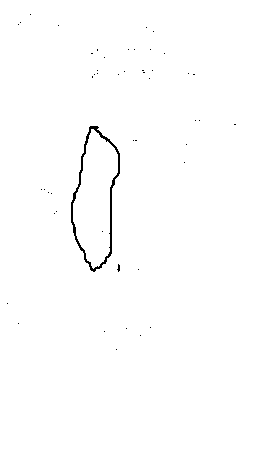

In [15]:
cv2_imshow(th_left_cropped_images[92])

**3rd. Aggregate the pixels to generate new positions that will help us to identify better the position of each vehicle and the specific part where it was affected**

In [16]:
os.chdir('/content/capstone_project')

In [17]:
# Set the font for the text
font = truetype('arial.ttf', 7)

# Set the number of rows and columns for the grid
rows = 24
cols = 12

grid_images = []

for i, image in enumerate(left_cropped_images):
    # Convert the image to a pillow image object
    image = Image.fromarray(image)

    # Create an ImageDraw object
    draw = ImageDraw.Draw(image)

    # Calculate the width and height of each grid square
    square_width = image.width // cols
    square_height = image.height // rows

    # Draw the grid lines
    
    # Draw the horizontal lines
    for i in range(rows + 1):
        y = i * square_height
        draw.line((0, y, image.width, y), fill=(255, 0, 0))

    # Draw the vertical lines
    for j in range(cols + 1):
        x = j * square_width
        draw.line((x, 0, x, image.height), fill=(255, 0, 0))

    # Add the index text to each grid square
    for i in range(rows):
        for j in range(cols):
            x = j * square_width + 5
            y = i * square_height + 5
            text = f'({i},{j})'
            draw.text((x, y), text, font=font, fill=(0, 0, 0))

    # Save the modified image
    grid_images.append(image)


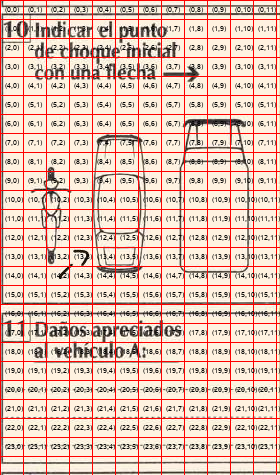

In [18]:
grid_images[71]

**Do the same procedure but with the thresholded images**



In [19]:
# Set the font for the text
font = truetype('arial.ttf', 7)


th_grid_images = []
coordinates = []

for i, image in enumerate(th_left_cropped_images):
    # Convert the image to a pillow image object
    image = Image.fromarray(image)

    # Create an ImageDraw object
    draw = ImageDraw.Draw(image)

    # Calculate the width and height of each grid square
    square_width = image.width // cols
    square_height = image.height // rows

    # Draw the grid lines
    for i in range(rows + 1):
        y = i * square_height
        draw.line((0, y, image.width, y), fill=(100))

    for j in range(cols + 1):
        x = j * square_width
        draw.line((x, 0, x, image.height), fill=(100))

    # Add the coordinates of each grid square to a list
    coord_list = []
    for i in range(rows):
        for j in range(cols):
            coord_list.append((i, j))
    coordinates.append(coord_list)

    
    # Add the index text to each grid square
    for i in range(rows):
        for j in range(cols):
            x = j * square_width + 5
            y = i * square_height + 5
            text = f'({i},{j})'
            draw.text((x, y), text, font=font, fill=(0))
  
    # Save the modified image
    th_grid_images.append(image)


This code returns 2 outputs:

- `th_grid_images`: list of images that shows the thresholded images with the grid drawn and the coordinate written on each square.
- `coordinates`: list of lists of coordinates per image, this is just a transitory variable we will use after creating the percentage of black per each image to do the classification. 

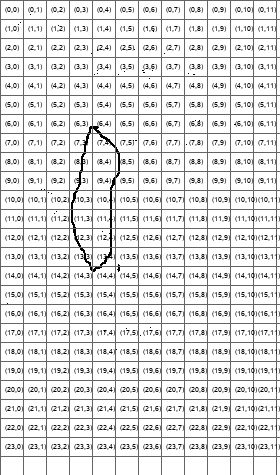

In [20]:
th_grid_images[92]

In [21]:
len(coordinates[92])

288

 ## Read the written comments below!!!!

- Now we have to define per grid, which corresponds to the type of vehicle and to the part it was affected (label each grid). 
- Additionally, we have to find the way to apply this labeled grids on the thresholded images (the grids that have higher percentage of black over the grid should give us the information we need).

In [22]:
# Set the font for the text
font = truetype('arial.ttf', 7)

perc_th_grid_images = []
percentages = []

for i, image in enumerate(th_left_cropped_images):
    # Convert the image to a pillow image object
    image = Image.fromarray(image)

    # Create an ImageDraw object
    draw = ImageDraw.Draw(image)

    # Calculate the width and height of each grid square
    square_width = image.width // cols
    square_height = image.height // rows

    # Draw the grid lines
    for i in range(rows + 1):
        y = i * square_height
        draw.line((0, y, image.width, y), fill=(100))

    for j in range(cols + 1):
        x = j * square_width
        draw.line((x, 0, x, image.height), fill=(100))

    # Add the black pixel percentage text to each grid square
    black_percentages = []
    for i in range(rows):
        for j in range(cols):
            x = j * square_width + 5
            y = i * square_height + 5

            # Calculate the number of black pixels inside the square
            black_pixels = 0
            for row in range(i * square_height, (i + 1) * square_height):
                for col in range(j * square_width, (j + 1) * square_width):
                    if image.getpixel((col, row)) == 0:
                        black_pixels += 1

            # Calculate the total number of pixels inside the square
            total_pixels = square_width * square_height

            # Calculate the percentage of black pixels
            black_percentage = black_pixels / total_pixels * 100

            # Add the percentage to the black_percentages list
            black_percentages.append(black_percentage)

            # Convert the percentage to a string and add it to the text
            text = f'{black_percentage:.2f}%'

            # Draw the text inside the square
            draw.text((x, y), text, font=font, fill=(0))

    # Add the black_percentages list to the percentages list
    percentages.append(black_percentages)

    # Save the modified image
    perc_th_grid_images.append(image)



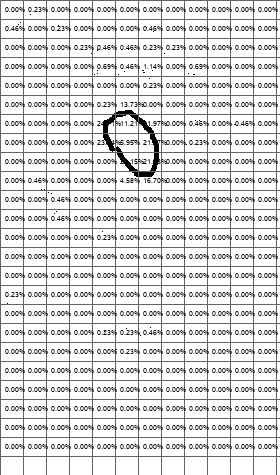

In [23]:
perc_th_grid_images[8]

In [24]:
# Create an empty dictionary
coordinate_labels = {}


# Iterate over the rows and columns of the grid
for i in range(rows):
    for j in range(cols):
        # Calculate the coordinate
        coordinate = (i, j)

        # Set the label based on the coordinate
        if (i == 8 and j == 1) or (i == 8 and j == 2) or (i == 7 and j == 1) or (i == 7 and j == 2) or (i == 6 and j == 1) or (i == 6 and j == 2) or (i == 9 and j == 0) or (i == 9 and j == 1) or (i == 9 and j == 2):
            label = 'front motorbike'
        elif   (i == 10 and j == 0) or (i == 10 and j == 1) or (i == 11 and j == 0) or (i == 11 and j == 1) or (i == 12 and j == 0) or (i == 12 and j == 1):
            label = 'left motorbike'
        elif  (i == 10 and j == 2) or (i == 11 and j == 2) or (i == 12 and j == 2):
            label = 'right motorbike'
        elif  (i == 13 and j == 1) or (i == 13 and j == 2) or (i == 14 and j == 1) or (i == 14 and j == 2) or (i == 15 and j == 1) or (i == 15 and j == 2):
            label = 'back motorbike'
        elif  (i == 5 and j == 3) or (i ==5 and j == 4) or (i == 5 and j == 5) or (i == 5 and j == 6) or (i == 6 and j == 3) or (i == 6 and j == 4) or (i == 6 and j == 5) or (i == 6 and j == 6) or (i == 7 and j == 3) or (i ==7 and j == 4) or (i == 7 and j == 5) or (i == 7 and j == 6):
            label = 'front car'
        elif  (i == 8 and j == 3) or (i ==8 and j == 4) or (i == 9 and j == 3) or (i == 9 and j == 4) or (i == 10 and j == 3) or (i == 10 and j == 4) or (i == 11 and j == 3) or (i == 11 and j == 4) or (i == 12 and j == 3) or (i ==12 and j == 4):
            label = 'left car'
        elif  (i == 8 and j ==5) or (i ==8 and j == 6) or (i == 9 and j == 5) or (i == 9 and j == 6) or (i == 10 and j == 5) or (i == 10 and j == 6) or (i == 11 and j == 5) or (i == 11 and j == 6) or (i == 12 and j == 5) or (i ==12 and j == 6):
            label = 'right car'
        elif  (i == 13 and j ==3 ) or (i ==13 and j == 4) or (i == 13 and j == 5) or (i == 13 and j == 6) or (i == 14 and j == 3) or (i == 14 and j == 4) or (i == 14 and j == 5) or (i == 14 and j == 6) or (i ==15 and j == 3) or (i ==15 and j == 4) or (i ==15 and j == 5) or (i ==15 and j == 6):
            label = 'back car'
        elif  (i == 4 and j == 7 ) or (i == 4 and j == 8) or (i == 4 and j == 9) or (i == 4 and j == 10) or (i == 4 and j == 11) or (i == 5 and j == 7) or (i == 5 and j == 8) or (i == 5 and j == 9) or (i == 5 and j == 10) or (i ==5 and j == 11) or (i == 6 and j == 7) or (i == 6 and j == 8) or (i ==6 and j == 9) or (i ==6 and j == 10) or (i ==6 and j == 11) or (i == 7 and j == 7 ) or (i == 7 and j == 8) or (i == 7 and j == 9) or (i == 7 and j == 10) or (i == 7 and j == 11):
            label = 'front truck'          
        elif  (i == 8 and j == 7 ) or (i == 9 and j == 7) or (i == 10 and j == 7) or (i == 11 and j == 7) or (i == 12 and j == 7) or (i == 8 and j == 8 ) or (i == 9 and j == 8) or (i == 10 and j == 8) or (i == 11 and j == 8) or (i == 12 and j == 8) :
            label = 'left truck'
        elif  (i == 8 and j == 10 ) or (i == 9 and j == 10) or (i == 10 and j == 10) or (i == 11 and j == 10) or (i == 12 and j == 10) or (i == 8 and j == 11 ) or (i == 9 and j == 11) or (i == 10 and j == 11) or (i == 11 and j == 11) or (i == 12 and j == 11):
            label = 'right truck'
        elif  (i == 14 and j == 7 ) or (i == 14 and j == 8) or (i == 14 and j == 9) or (i == 14 and j == 10) or (i == 14 and j == 11) or (i == 15 and j == 7) or (i == 15 and j == 8) or (i == 15 and j == 9) or (i == 15 and j == 10) or (i == 15 and j == 11) or (i == 13 and j == 11) or (i == 13 and j == 10) or (i == 13 and j == 7) or (i == 13 and j == 8) or (i == 13 and j == 9):
            label = 'back truck'  
        else:
            label = 'Other'

        # Add the coordinate and label to the dictionary
        coordinate_labels[coordinate] = label


In [25]:
d_bpercentages = {i: value for i, value in enumerate(percentages)}

In [26]:
labels = ['Other', 'front motorbike', 'back motorbike', 'left motorbike', 'right motorbike', 'front car', 'back car', 'left car', 'right car', 'front truck', 'back truck', 'left truck', 'right truck']

In [27]:
def sum_black_percentages_per_label(image_number, label, d_bpercentages, coordinate_labels):
    percentages = d_bpercentages[image_number]
    sum_percentage = 0
    pixel_number = 0
    for coord, coord_label in coordinate_labels.items():
        if coord_label == label:
            index = list(coordinate_labels.keys()).index(coord)
            sum_percentage += percentages[index]
            pixel_number += 1
    return (sum_percentage/pixel_number)



In [28]:
def find_highest_black_percentage_label(d_bpercentages, coordinate_labels, labels):
    image_label_dict = {}
    for image_number in range(len(d_bpercentages)):
        highest_sum = 0
        highest_label = None
        for label in labels:
            curr_sum = sum_black_percentages_per_label(image_number, label, d_bpercentages, coordinate_labels)
            if curr_sum > highest_sum:
              if curr_sum > 0.4: #Threshold to make sure the ones with no righting show "other"
                highest_sum = curr_sum
                highest_label = label
              else:
                highest_label = 'Other'
        image_label_dict[image_number] = highest_label
    return image_label_dict

In [29]:
print(find_highest_black_percentage_label(d_bpercentages, coordinate_labels, labels))

{0: 'right car', 1: 'left car', 2: 'left truck', 3: 'front car', 4: 'front car', 5: 'back truck', 6: 'front car', 7: 'left truck', 8: 'front car', 9: 'front car', 10: 'front car', 11: 'front car', 12: 'front motorbike', 13: 'front car', 14: 'front car', 15: 'front car', 16: 'front car', 17: 'front car', 18: 'right car', 19: 'front truck', 20: 'left motorbike', 21: 'front car', 22: 'front car', 23: 'left car', 24: 'front truck', 25: 'front car', 26: 'front car', 27: 'front truck', 28: 'right motorbike', 29: 'front truck', 30: 'right car', 31: 'right car', 32: 'Other', 33: 'front car', 34: 'Other', 35: 'front truck', 36: 'right car', 37: 'back car', 38: 'front car', 39: 'front car', 40: 'back car', 41: 'front car', 42: 'front car', 43: 'front car', 44: 'front motorbike', 45: 'right car', 46: 'front car', 47: 'back car', 48: 'front car', 49: 'front car', 50: 'front car', 51: 'left motorbike', 52: 'front car', 53: 'back car', 54: 'front car', 55: 'front car', 56: 'left car', 57: 'left car'

## Observaciones Errores Parte A:

*   Imagén #12 muestra impacto en "left Motorbike", se clasifica como "front Motorbike"
*   Imagén #28 muestra impacto en toda la moto al tener una X en la mitad, se clasifica como "right Motorbike"
*   Imagén #34 muestra impacto en "left/back Motorbike", se clasifica como "Other" (No sabemos porque pero con el threshold no muestra impacto)
*   Imagén #71 muestra impacto en "left Car", se clasifica como "back motorbike" (dada la forma dela flecha no tiene solución)













# Detection of type of vehicles (B)

**1st. Crop the images to keep only the B part needed**

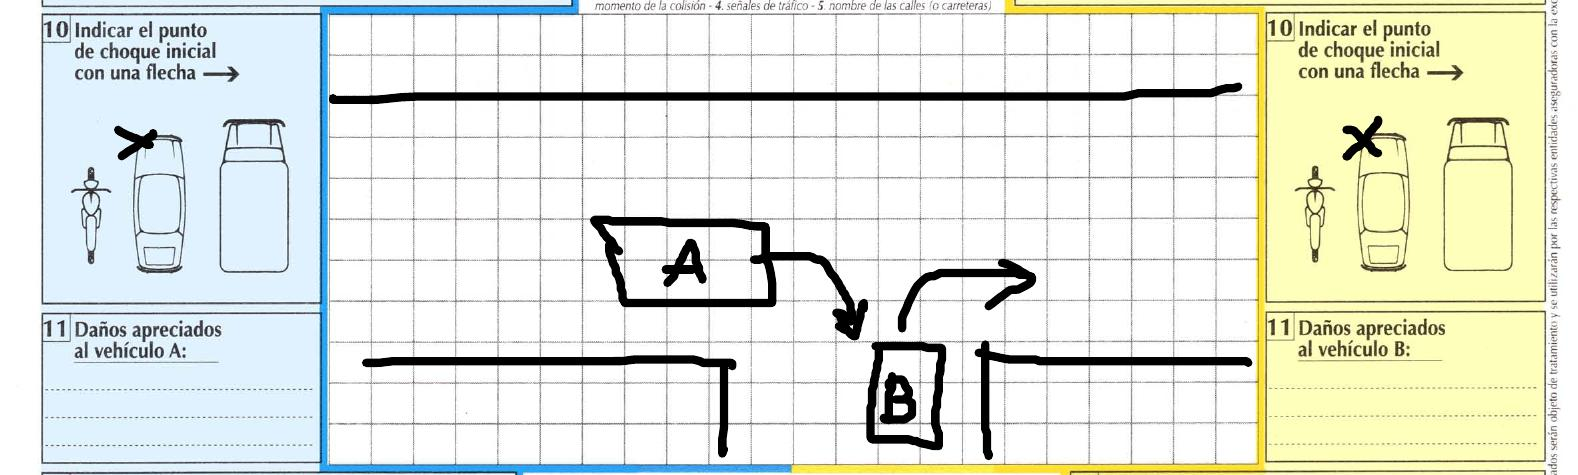

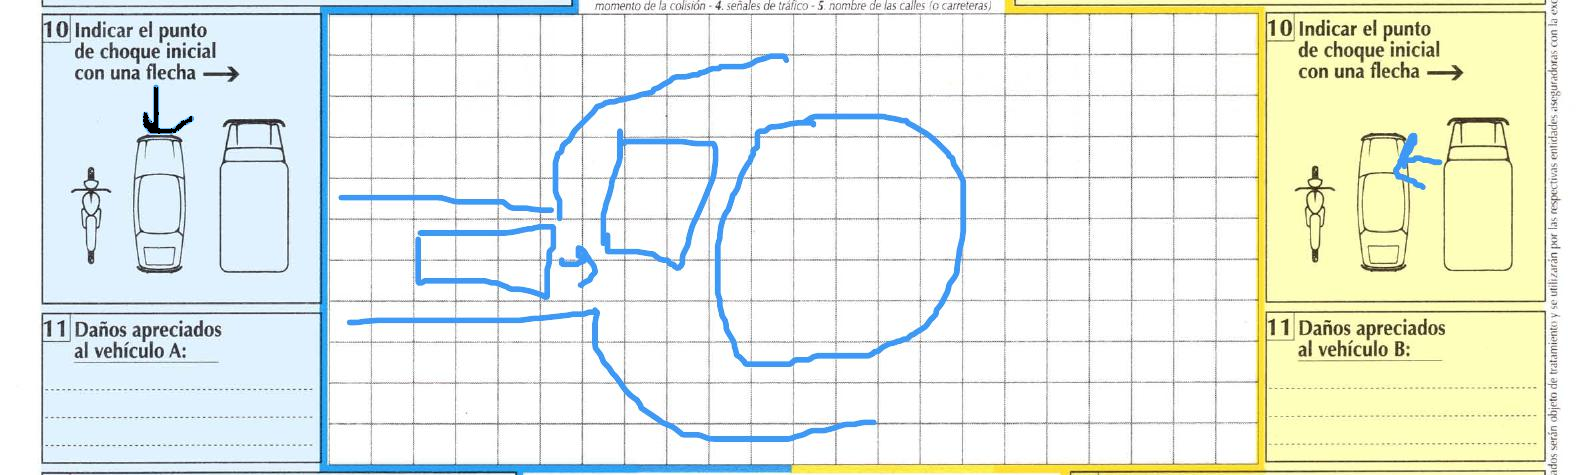

In [30]:
cv2_imshow(images[10])
cv2_imshow(images[49])

In [31]:
right_cropped_images = []
for image in images:
    height, width = image.shape[:2]
    cropped_image = image[:, 1265:1550]
    mask = (cropped_image[:,:,0] > 220) & (cropped_image[:,:,2] < 130)
    cropped_image[mask] = [0, 0, 0]
    mask = (cropped_image[:,:,2] > 220) & (cropped_image[:,:,0] < 100)
    cropped_image[mask] = [0, 0, 0]
    right_cropped_images.append(cropped_image)

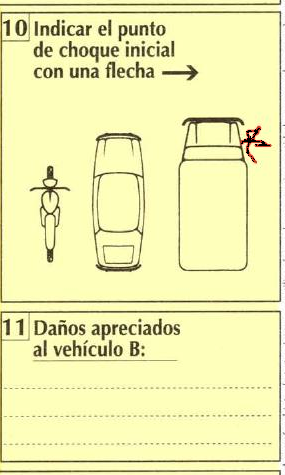

In [55]:
cv2_imshow(right_cropped_images[51])

2nd. Do the thresholding process to keep the extra lines drawn on the B image .

In [33]:
# Set the threshold value
threshold_value = 30
# Create an empty list to store the thresholded images
th_right_cropped_images = []

# Loop through the images in right_cropped_images
for image in right_cropped_images:
  # Convert the image to grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
  # Apply global thresholding
  _, threshold = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)
  
  # Add the thresholded image to the list
  th_right_cropped_images.append(threshold)

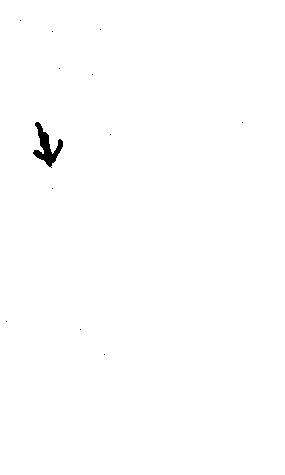

In [34]:
cv2_imshow(th_right_cropped_images[0])

3rd. Aggregate the pixels to generate new positions that will help us to identify better the position of each vehicle(B) and the specific part where it was affected

In [35]:
os.chdir('/content/capstone_project')

In [36]:
# Set the font for the text
font = truetype('arial.ttf', 7)

# Set the number of rows and columns for the grid
rows = 24
cols = 12

grid_images_B = []

for i, image in enumerate(right_cropped_images):
    # Convert the image to a pillow image object
    image = Image.fromarray(image)

    # Create an ImageDraw object
    draw = ImageDraw.Draw(image)

    # Calculate the width and height of each grid square
    square_width = image.width // cols
    square_height = image.height // rows

    # Draw the grid lines
    
    # Draw the horizontal lines
    for i in range(rows + 1):
        y = i * square_height
        draw.line((0, y, image.width, y), fill=(255, 0, 0))

    # Draw the vertical lines
    for j in range(cols + 1):
        x = j * square_width
        draw.line((x, 0, x, image.height), fill=(255, 0, 0))

    # Add the index text to each grid square
    for i in range(rows):
        for j in range(cols):
            x = j * square_width + 5
            y = i * square_height + 5
            text = f'({i},{j})'
            draw.text((x, y), text, font=font, fill=(0, 0, 0))

    # Save the modified image
    grid_images_B.append(image)

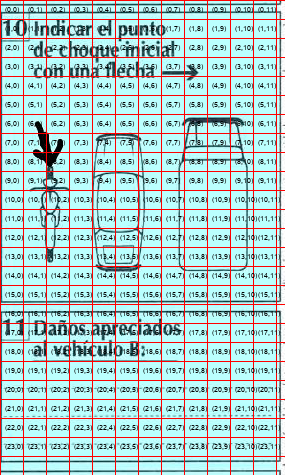

In [37]:
grid_images_B[0]

Do the same procedure but with the thresholded images(B)

In [38]:
# Set the font for the text
font = truetype('arial.ttf', 7)


th_grid_images_B = []
coordinates_B = []

for i, image in enumerate(th_right_cropped_images):
    # Convert the image to a pillow image object
    image = Image.fromarray(image)

    # Create an ImageDraw object
    draw = ImageDraw.Draw(image)

    # Calculate the width and height of each grid square
    square_width = image.width // cols
    square_height = image.height // rows

    # Draw the grid lines
    for i in range(rows + 1):
        y = i * square_height
        draw.line((0, y, image.width, y), fill=(100))

    for j in range(cols + 1):
        x = j * square_width
        draw.line((x, 0, x, image.height), fill=(100))

    # Add the coordinates of each grid square to a list
    coord_list = []
    for i in range(rows):
        for j in range(cols):
            coord_list.append((i, j))
    coordinates_B.append(coord_list)

    
    # Add the index text to each grid square
    for i in range(rows):
        for j in range(cols):
            x = j * square_width + 5
            y = i * square_height + 5
            text = f'({i},{j})'
            draw.text((x, y), text, font=font, fill=(0))
  
    # Save the modified image
    th_grid_images_B.append(image)

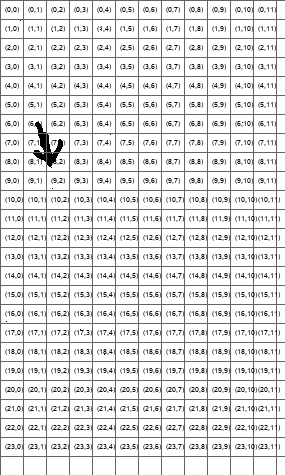

In [39]:

th_grid_images_B[0]

In [40]:
len(coordinates_B[50])

288

Now we have to define per grid, which corresponds to the type of vehicle and to the part it was affected (label each grid)

In [41]:
# Set the font for the text
font = truetype('arial.ttf', 7)

perc_th_grid_images_B = []
percentages_B = []

for i, image in enumerate(th_right_cropped_images):
    # Convert the image to a pillow image object
    image = Image.fromarray(image)

    # Create an ImageDraw object
    draw = ImageDraw.Draw(image)

    # Calculate the width and height of each grid square
    square_width = image.width // cols
    square_height = image.height // rows

    # Draw the grid lines
    for i in range(rows + 1):
        y = i * square_height
        draw.line((0, y, image.width, y), fill=(100))

    for j in range(cols + 1):
        x = j * square_width
        draw.line((x, 0, x, image.height), fill=(100))

    # Add the black pixel percentage text to each grid square
    black_percentages_B = []
    for i in range(rows):
        for j in range(cols):
            x = j * square_width + 5
            y = i * square_height + 5

            # Calculate the number of black pixels inside the square
            black_pixels = 0
            for row in range(i * square_height, (i + 1) * square_height):
                for col in range(j * square_width, (j + 1) * square_width):
                    if image.getpixel((col, row)) == 0:
                        black_pixels += 1

            # Calculate the total number of pixels inside the square
            total_pixels = square_width * square_height

            # Calculate the percentage of black pixels
            black_percentage = black_pixels / total_pixels * 100

            # Add the percentage to the black_percentages list
            black_percentages_B.append(black_percentage)

            # Convert the percentage to a string and add it to the text
            text = f'{black_percentage:.2f}%'

            # Draw the text inside the square
            draw.text((x, y), text, font=font, fill=(0))

    # Add the black_percentages list to the percentages list
    percentages_B.append(black_percentages_B)

    # Save the modified image
    perc_th_grid_images_B.append(image)

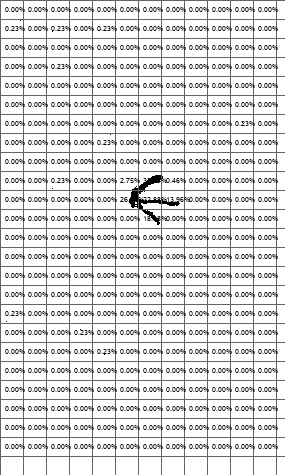

In [42]:
perc_th_grid_images_B[33]

In [43]:
# Create an empty dictionary
coordinate_labels_B = {}


# Iterate over the rows and columns of the grid
for i in range(rows):
    for j in range(cols):
        # Calculate the coordinate
        coordinate = (i, j)

        # Set the label based on the coordinate
        if (i == 8 and j == 0) or (i == 8 and j == 1) or (i == 8 and j == 2) or (i == 7 and j == 0) or (i == 7 and j == 1) or (i == 7 and j == 2) or (i == 6 and j == 1) or (i == 6 and j == 2) or (i == 9 and j == 0) or (i == 9 and j == 1) or (i == 9 and j == 2):
            label = 'front motorbike'
        elif   (i == 10 and j == 0) or (i == 10 and j == 1) or (i == 11 and j == 0) or (i == 11 and j == 1) or (i == 12 and j == 0) or (i == 12 and j == 1):
            label = 'left motorbike'
        elif  (i == 10 and j == 2) or (i == 11 and j == 2) or (i == 12 and j == 2):
            label = 'right motorbike'
        elif  (i == 13 and j == 1) or (i == 13 and j == 2) or (i == 14 and j == 1) or (i == 14 and j == 2) or (i == 15 and j == 1) or (i == 15 and j == 2):
            label = 'back motorbike'
        elif  (i == 5 and j == 3) or (i ==5 and j == 4) or (i == 5 and j == 5) or (i == 5 and j == 6) or (i == 6 and j == 3) or (i == 6 and j == 4) or (i == 6 and j == 5) or (i == 6 and j == 6) or (i == 7 and j == 3) or (i ==7 and j == 4) or (i == 7 and j == 5) or (i == 7 and j == 6):
            label = 'front car'
        elif  (i == 8 and j == 3) or (i ==8 and j == 4) or (i == 9 and j == 3) or (i == 9 and j == 4) or (i == 10 and j == 3) or (i == 10 and j == 4) or (i == 11 and j == 3) or (i == 11 and j == 4) or (i == 12 and j == 3) or (i ==12 and j == 4):
            label = 'left car'
        elif  (i == 8 and j ==5) or (i ==8 and j == 6) or (i == 9 and j == 5) or (i == 9 and j == 6) or (i == 10 and j == 5) or (i == 10 and j == 6) or (i == 11 and j == 5) or (i == 11 and j == 6) or (i == 12 and j == 5) or (i ==12 and j == 6):
            label = 'right car'
        elif  (i == 13 and j ==3 ) or (i ==13 and j == 4) or (i == 13 and j == 5) or (i == 13 and j == 6) or (i == 14 and j == 3) or (i == 14 and j == 4) or (i == 14 and j == 5) or (i == 14 and j == 6) or (i ==15 and j == 3) or (i ==15 and j == 4) or (i ==15 and j == 5) or (i ==15 and j == 6):
            label = 'back car'
        elif  (i == 4 and j == 7 ) or (i == 4 and j == 8) or (i == 4 and j == 9) or (i == 4 and j == 10) or (i == 4 and j == 11) or (i == 5 and j == 7) or (i == 5 and j == 8) or (i == 5 and j == 9) or (i == 5 and j == 10) or (i ==5 and j == 11) or (i == 6 and j == 7) or (i == 6 and j == 8) or (i ==6 and j == 9) or (i ==6 and j == 10) or (i ==6 and j == 11) or (i == 7 and j == 7 ) or (i == 7 and j == 8) or (i == 7 and j == 9) or (i == 7 and j == 10) or (i == 7 and j == 11):
            label = 'front truck'          
        elif  (i == 8 and j == 7 ) or (i == 9 and j == 7) or (i == 10 and j == 7) or (i == 11 and j == 7) or (i == 12 and j == 7) or (i == 8 and j == 8 ) or (i == 9 and j == 8) or (i == 10 and j == 8) or (i == 11 and j == 8) or (i == 12 and j == 8):
            label = 'left truck'
        elif  (i == 8 and j == 10 ) or (i == 9 and j == 10) or (i == 10 and j == 10) or (i == 11 and j == 10) or (i == 12 and j == 10) or (i == 8 and j == 11 ) or (i == 9 and j == 11) or (i == 10 and j == 11) or (i == 11 and j == 11) or (i == 12 and j == 11):
            label = 'right truck'
        elif  (i == 14 and j == 7 ) or (i == 14 and j == 8) or (i == 14 and j == 9) or (i == 14 and j == 10) or (i == 14 and j == 11) or (i == 15 and j == 7) or (i == 15 and j == 8) or (i == 15 and j == 9) or (i == 15 and j == 10) or (i == 15 and j == 11) or (i == 13 and j == 11) or (i == 13 and j == 10) or (i == 13 and j == 8) or (i == 13 and j == 7) or (i == 13 and j == 9):
            label = 'back truck'  
        else:
            label = 'Other'

        # Add the coordinate and label to the dictionary
        coordinate_labels_B[coordinate] = label

In [44]:
d_bpercentages = {i: value for i, value in enumerate(percentages_B)}

In [45]:
labels = ['Other', 'front motorbike', 'back motorbike', 'left motorbike', 'right motorbike', 'front car', 'back car', 'left car', 'right car', 'front truck', 'back truck', 'left truck', 'right truck']

In [46]:
def sum_black_percentages_per_label_B(image_number, label, d_bpercentages, coordinate_labels_B):
    percentages_B = d_bpercentages[image_number]
    sum_percentage_B = 0
    pixel_number_B = 0
    for coord, coord_label in coordinate_labels.items():
        if coord_label == label:
            index = list(coordinate_labels_B.keys()).index(coord)
            sum_percentage_B += percentages_B[index]
            pixel_number_B += 1
    return (sum_percentage_B/pixel_number_B)



In [47]:
def find_highest_black_percentage_label_B(d_bpercentages, coordinate_labels_B, labels):
    image_label_dict_B = {}
    for image_number in range(len(d_bpercentages)):
        highest_sum = 0
        highest_label = None
        for label in labels:
            curr_sum = sum_black_percentages_per_label_B(image_number, label, d_bpercentages, coordinate_labels_B)
            if curr_sum > highest_sum:
              if curr_sum > 0.1: #Threshold to make sure the ones with no righting show "other"
                highest_sum = curr_sum
                highest_label = label
              else:
                highest_label = 'Other'
        image_label_dict_B[image_number] = highest_label
    return image_label_dict_B

In [48]:
find_highest_black_percentage_label_B(d_bpercentages, coordinate_labels_B, labels)

{0: 'front motorbike',
 1: 'front car',
 2: 'front car',
 3: 'right motorbike',
 4: 'left car',
 5: 'front car',
 6: 'front car',
 7: 'front car',
 8: 'left motorbike',
 9: 'right motorbike',
 10: 'front car',
 11: 'left truck',
 12: 'front car',
 13: 'front car',
 14: 'front car',
 15: 'front car',
 16: 'front car',
 17: 'left motorbike',
 18: 'front truck',
 19: 'back truck',
 20: 'front car',
 21: 'front car',
 22: 'right car',
 23: 'front truck',
 24: 'right motorbike',
 25: 'back truck',
 26: 'Other',
 27: 'back truck',
 28: 'front car',
 29: 'front car',
 30: 'left car',
 31: 'front car',
 32: 'Other',
 33: 'right car',
 34: 'Other',
 35: 'left motorbike',
 36: 'left car',
 37: 'front car',
 38: 'left car',
 39: 'back car',
 40: 'front truck',
 41: 'front motorbike',
 42: 'back car',
 43: 'right car',
 44: 'back motorbike',
 45: 'left car',
 46: 'back car',
 47: 'front car',
 48: 'back car',
 49: 'right car',
 50: 'front car',
 51: 'front truck',
 52: 'right car',
 53: 'front car

## Observaciones Errores Parte B:

*   Imagen #51 muestra impacto en "left Truck", se clasifica como "front Truck" (está demasiado alante, habría que cambiar la clasificación de las coordenadas y no merece la pena)
*   Imagen #59 muestra impacto en "left Car", se clasifica como "front Car" (mismo problema que con la 51)







